In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import math

from pandas import read_csv
from scipy.optimize import curve_fit
import pickle

import czifile
import cv2

from scipy import stats

import seaborn as sns
import copy


# 2D scan

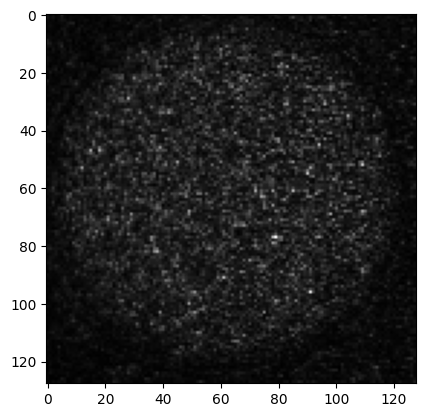

In [2]:
foldername='/Volumes/wwyyrx/Wenyun/Silk_speckle/20230524/'

h, w = 128,128

imgname='30min_age_3'

# Read the CZI file
data = czifile.imread(foldername+imgname+'.czi')
framespeed=0.13

plt.imshow(data[0, 1, 0, 0, :, :, 0], cmap='gray')
plt.show()

## calculate spatial correlation

In [3]:
def spatial_correlation(example_img, sp_shape,ROI):
    y_length=example_img.shape[0]
    x_length=example_img.shape[1]
    num_pixels=y_length*x_length
    spcorrelation_map = np.zeros((sp_shape,sp_shape))
    for dy in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
        for dx in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
            sum_numerator=0
            sum_denum_1=0
            sum_denum_2=0
            count=0
            for y in range(ROI[0],ROI[0]+ROI[2],1):
                for x in range(ROI[1],ROI[1]+ROI[3],1):
                    sum_numerator+=int(example_img[y][x])*int(example_img[y+dy][x+dx])
                    sum_denum_1+=int(example_img[y][x])
                    sum_denum_2+=int(example_img[y+dy][x+dx])
                    count+=1
            numerator=sum_numerator/count
            denum_1=sum_denum_1/count
            denum_2=sum_denum_2/count
            spcorrelation_map[dy+math.floor(sp_shape/2)][dx+math.floor(sp_shape/2)]=copy.deepcopy(numerator/(denum_1*denum_2)-1)
    normalization=spcorrelation_map[math.floor(sp_shape/2)][math.floor(sp_shape/2)]
    spcorrelation_map=spcorrelation_map/normalization
    sns.heatmap(spcorrelation_map)
    return spcorrelation_map

In [4]:
def plot_spmap(spcorrelation_map):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.')
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [pixels]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

In [5]:
def calculate_speckle_size(spcorrelation_map,startidx,endidx,plotBoolean=True):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    radius_squared=radius_flatten*radius_flatten
    log_correlation=np.log(abs(spcorrelation_map_flatten))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a, b= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective(x_line, a, b)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a, b= popt
        return np.sqrt(-1/a)

def objective(x, a,b):
	return a * x+b

In [6]:
def reconstruct_curve(spcorrelation_map,a):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.concatenate(radius).flat
    spcorrelation_map_flatten=np.concatenate(spcorrelation_map).flat
    y=np.zeros(len(radius_flatten))
    for i in range(0, len(radius_flatten),1):
        y[i]=(math.exp(a*radius_flatten[i]))
    plt.figure(figsize=(8,5))
    plt.plot(radius_flatten,y,'*',label="fit line")
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)

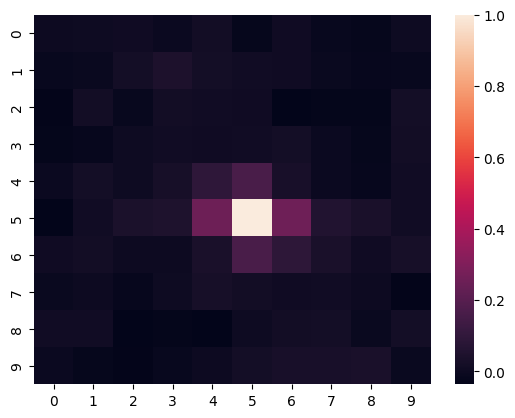

In [7]:
img_cal=data[0, 1, 0, 0, :, :, 0]
ROI=[35,35,50,50] #y,x,w,h
sp_shape=10
spmap=spatial_correlation(img_cal,sp_shape,ROI)

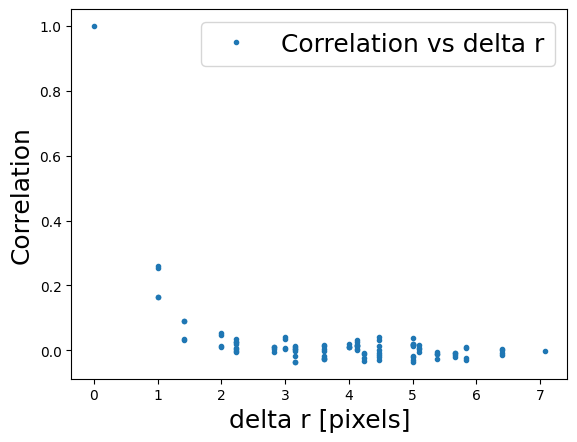

In [8]:
plot_spmap(spmap)

speckle size is: 0.8142053615401289
y = -1.50845 * x


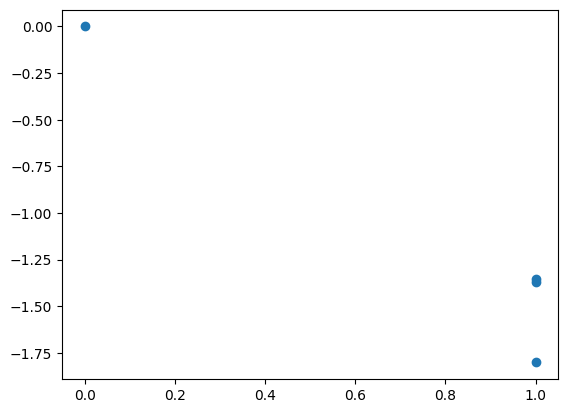

In [9]:
size,a =calculate_speckle_size(spmap,0,4)

## gaussian blur data

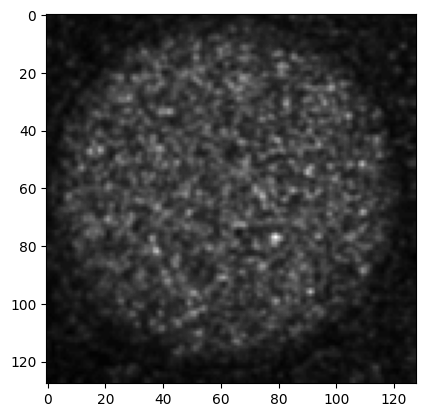

In [10]:
# apply a gaussian blur
for t in range(0,data.shape[1],1):
    data[0,t,0,0,:,:,0]=cv2.GaussianBlur(data[0,t,0,0,:,:,0], (3,3), size)

plt.imshow(data[0, 1, 0, 0, :, :, 0], cmap='gray')
plt.show()

## calculate correlation curve

In [11]:
def vectorized_compute_g2t_wo_kernel(px_indices, laglist_g2t, start_t, max_t_range, data, normalize=True, plot=False):
    print(px_indices)
    # Extract the intensity values for all px indices at once
    # Assuming 'data' is a 5D array and px_indices is a 2D array with shape (n, 2)
    intensities = data[0, :, 0, 0, px_indices[:, 0], px_indices[:, 1], 0]

    intensities = np.array(intensities,dtype=float)
    # print(intensities.shape)
    
    g2t_results = np.zeros((px_indices.shape[0], len(laglist_g2t)))

    # Loop over laglist_g2t
    for idx, lag in enumerate(laglist_g2t):
        # Vectorized computation for numerator and denominator
        numerator = (intensities[:, start_t:start_t + max_t_range] * intensities[:, start_t + lag:start_t + max_t_range + lag]).mean(axis=1)
        
        denominator1 = intensities[:, start_t:start_t + max_t_range].mean(axis=1)
        denominator2 = intensities[:, start_t + lag:start_t + max_t_range + lag].mean(axis=1)
        g2t_results[:, idx] = (np.array(numerator[:]) / (np.array(denominator1[:]) * np.array(denominator2[:]))) - 1

    # Normalization
    if normalize:
        first = g2t_results[:, 0].reshape(-1, 1)  # Reshape 'first' to be a column vector
        g2t_results /= first
    # if normalize:
    #     first = g2t_results[:, 0]
    #     for idx, lag in enumerate(laglist_g2t):
    #         g2t_results[:, idx] /= first


    # Plotting (if required)
    if plot:
        plt.figure(figsize=(8,5))
        for intensity in intensities:
            plt.plot(intensity[:200], 'k-')
        plt.xlabel("Time point", fontsize=18)
        plt.ylabel("Intensity", fontsize=18)
        plt.tick_params(direction='in')
        plt.show()

    return g2t_results


def create_circular_mask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


In [12]:
int(5.0/framespeed)

38

In [13]:
corrmaps_v = np.empty((h, w), dtype=object)  # or the appropriate dtype for your data
max_lag=int(15.0/framespeed)
print(max_lag)
laglist_g2t = np.arange(0, max_lag, 1)

# Create a grid of indices for the entire array
i_indices, j_indices = np.indices((h, w))

# Vectorized computation for the whole array
results = vectorized_compute_g2t_wo_kernel(np.stack((i_indices, j_indices), axis=-1).reshape(-1, 2),
                                laglist_g2t, 272, 911-max_lag-272, data)

# # Reshape results to match the 2D structure of corrmaps
corrmaps_v = results.reshape(h, w, max_lag)


115
[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [127 125]
 [127 126]
 [127 127]]


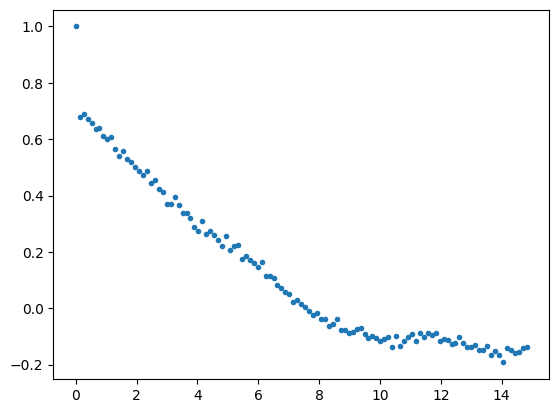

In [14]:
time_data = [ele *framespeed for ele in laglist_g2t]
plt.plot(np.array(time_data),corrmaps_v[63][57],'.')

/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_90465/2581362919.py:13: RuntimeWarning: invalid value encountered in log
  axs_flat[plot_index].plot(time_data, np.log(corrmaps_v[x, y, :]), '.')  # Adjust indexing for corrmaps_v


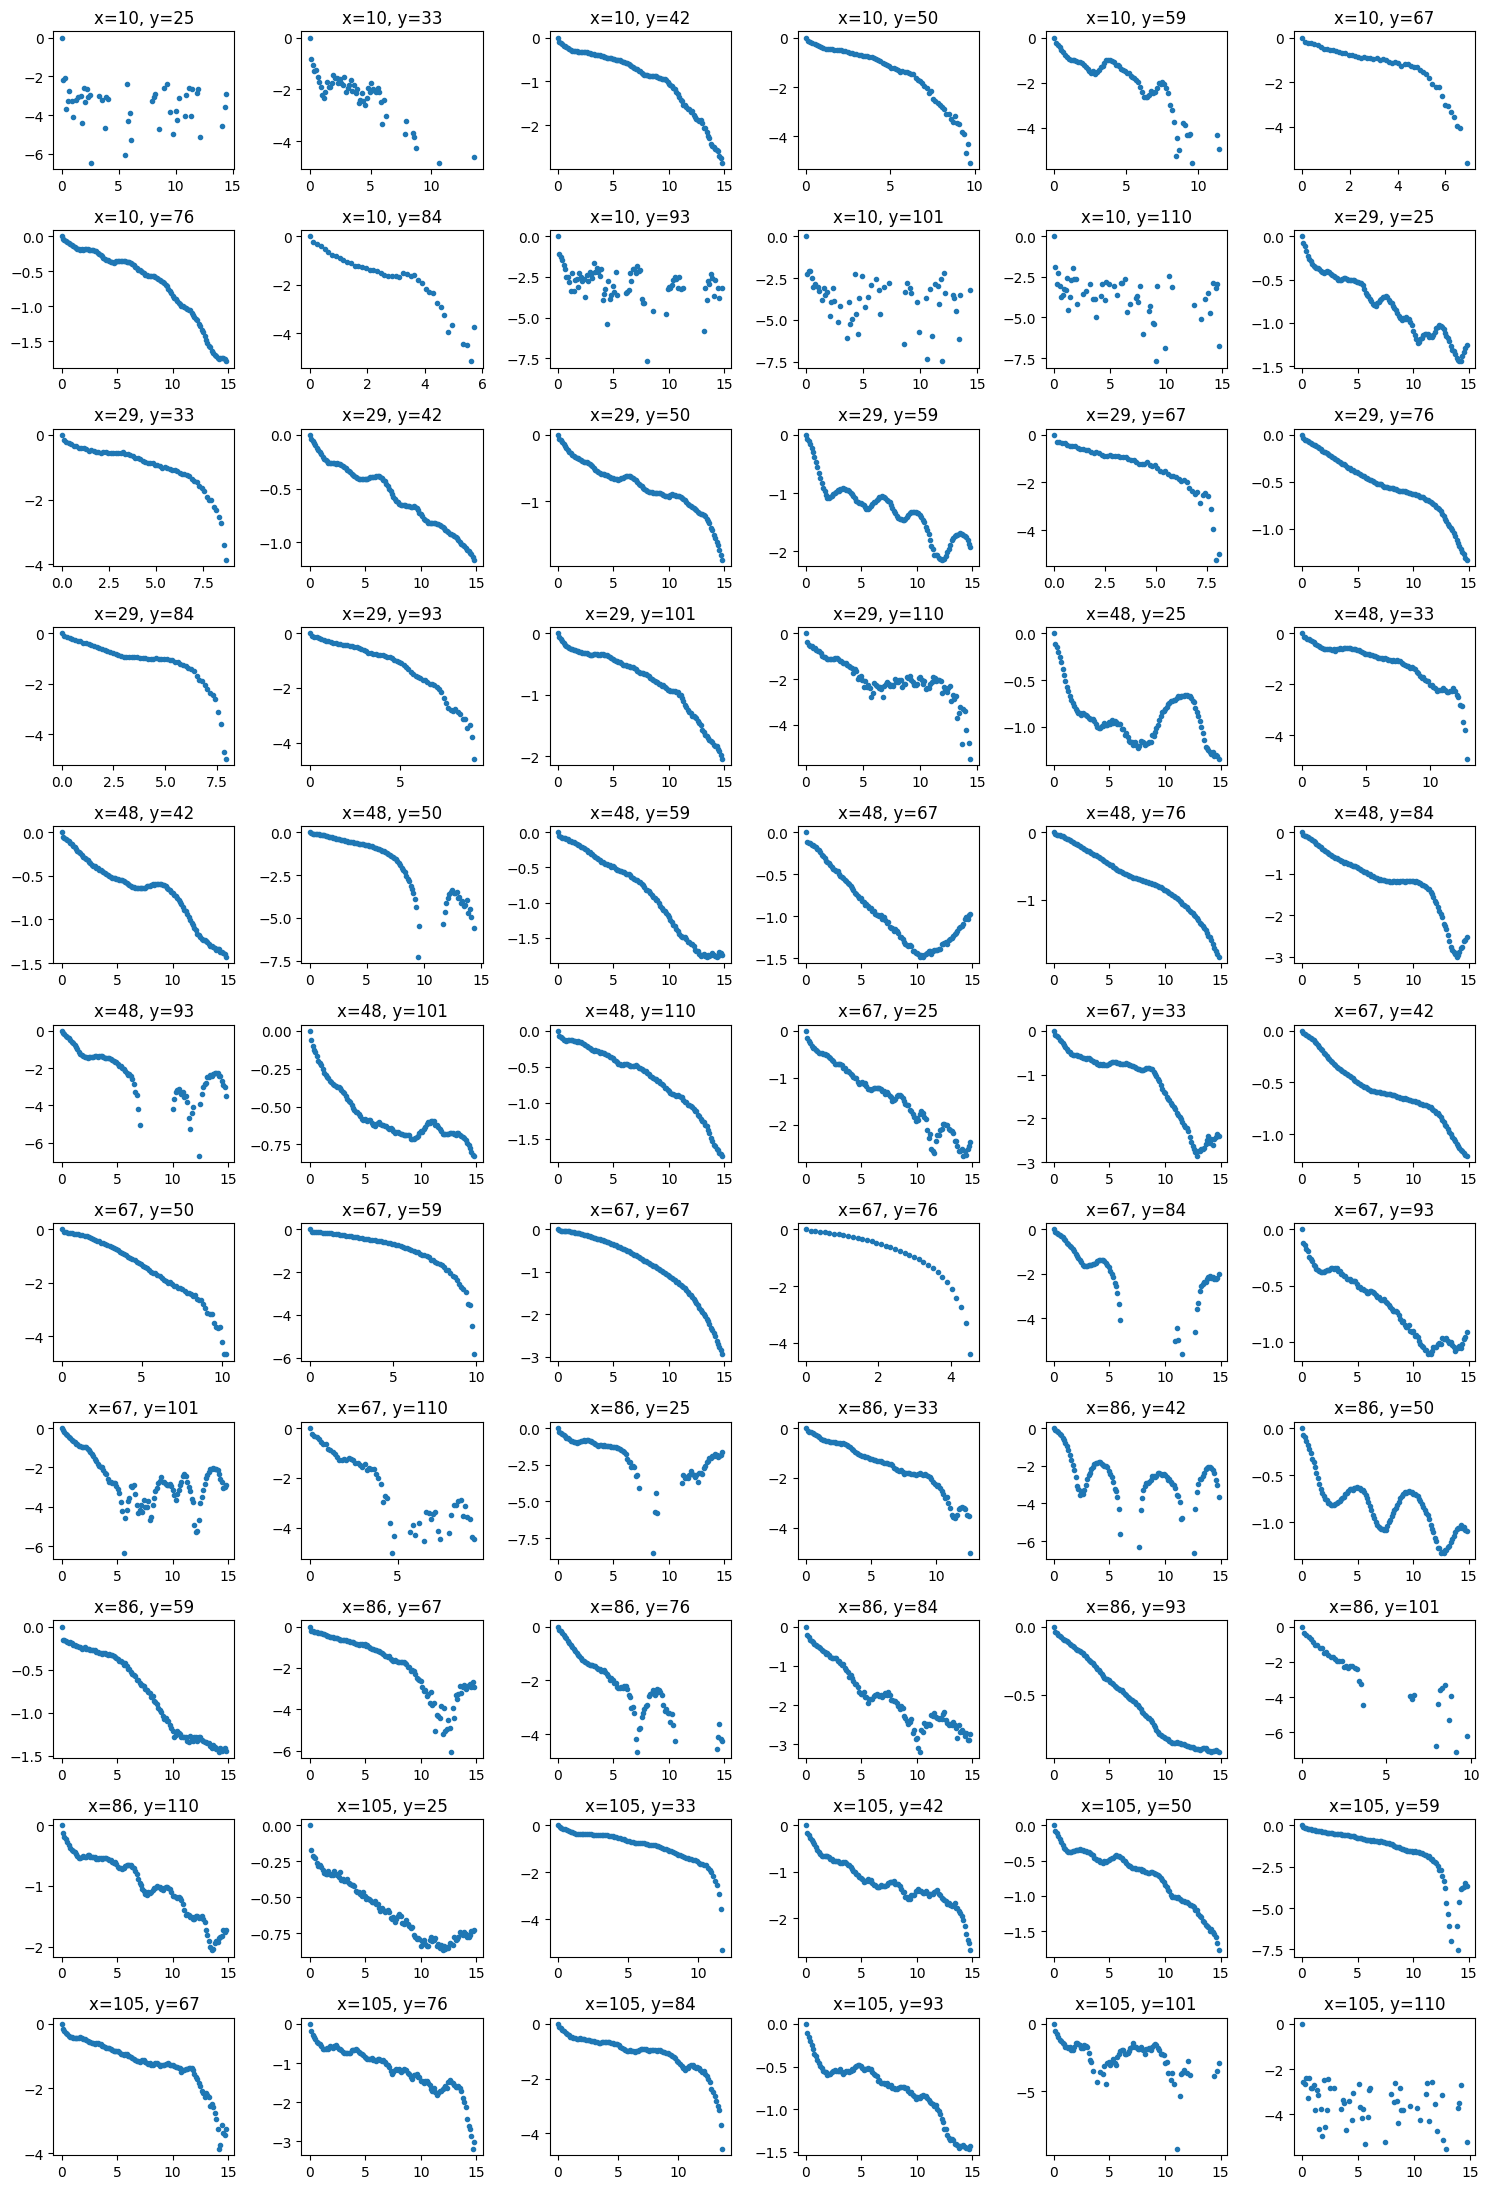

In [15]:
fig, axs = plt.subplots(11, 6, figsize=(15, 22))  # 11 rows and 6 columns to fit 66 plots
axs_flat = axs.flatten()

plot_index = 0
x_values = np.linspace(10, 105, 6, dtype=int)  # Convert to integer
y_values = np.linspace(25, 110, 11, dtype=int)  # Convert to integer

for x in x_values:
    for y in y_values:
        # Ensure x and y are used as indices within their valid range in 'corrmaps_v'
        if x >= corrmaps_v.shape[0] or y >= corrmaps_v.shape[1]:
            continue  # Skip invalid indices
        axs_flat[plot_index].plot(time_data, np.log(corrmaps_v[x, y, :]), '.')  # Adjust indexing for corrmaps_v
        axs_flat[plot_index].set_title(f"x={x}, y={y}")  # Optional: Add titles
        if plot_index < len(axs_flat) - 1:  # Prevent going out of bounds
            plot_index += 1

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

<AxesSubplot: >

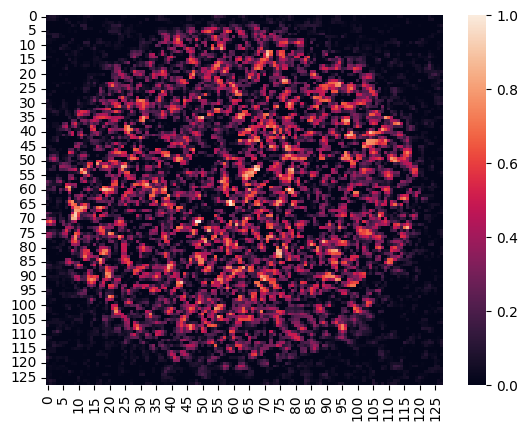

In [16]:
sns.heatmap(corrmaps_v[:,:,int(10.0/framespeed)],vmin=0,vmax=1)

# correlation function of the middle regione

In [17]:
img=data[0, 272:911, 0, 0, :, :, 0]

In [18]:
img.shape

(639, 128, 128)

In [19]:
#kernel_size is half of the total window size
def TRC(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest,normalize=True):
    correlation_2d=np.zeros((len(t_interest),len(tau_interest)))
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i, j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    intensity = np.array(intensity,dtype=float)
    print(intensity.shape)
    # compute correlation
    for t in t_interest:
        for tau in tau_interest:
            numerator=[]
            denum1=[]
            denum2=[]
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
            correlation_2d[t,tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
        if normalize:
            first=correlation_2d[t,0]
            for tau in tau_interest:
                correlation_2d[t,tau]=correlation_2d[t,tau]/first
    return correlation_2d

In [20]:
laglist_g2t=range(0,int(15.0/framespeed),1)
t_range=range(0,500,1)
TRC_corr=TRC([60,60],15,15,t_range,laglist_g2t)
TRC_correlation=np.mean(TRC_corr,axis=0)

(615, 900)


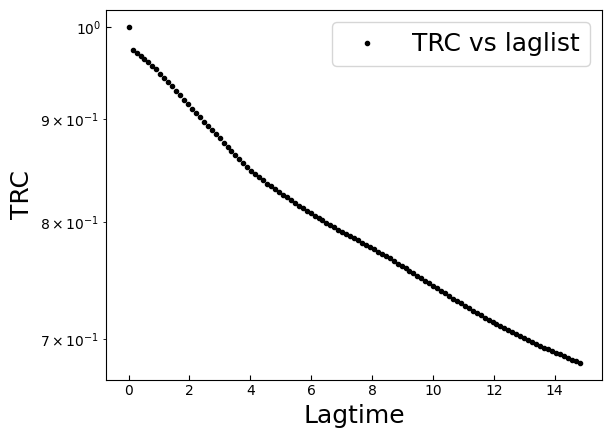

In [21]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.plot(lagtime_g2t,TRC_correlation[:],'k.')
plt.legend(['TRC vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("TRC",fontsize=18)
plt.tick_params(direction='in')
plt.yscale('log')
#plt.xscale('log')

In [22]:
file_path = '/Volumes/wwyyrx/Wenyun/Silk_speckle/analysis/30min_trc.pkl'

# Saving the array in a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(TRC_correlation, file)

# 